# Time Series Case Study

## First Example
The data and the exponential smoothing, ARIMA/SARIMA code from this notebook can be seen from this medium blog:

https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3

while the prophet and LSTM forecastings are original.

## Second Example

IBM stocks prediction. Data from:

https://www.macrotrends.net/stocks/charts/IBM/ibm/stock-price-history

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

### Install ipywidgets

https://stackoverflow.com/questions/53247985/tqdm-4-28-1-in-jupyter-notebook-intprogress-not-found-please-update-jupyter-an

In [2]:
ls data

LSTM2.png        ads1.csv         currency.csv
ads.csv          analytics_1.csv


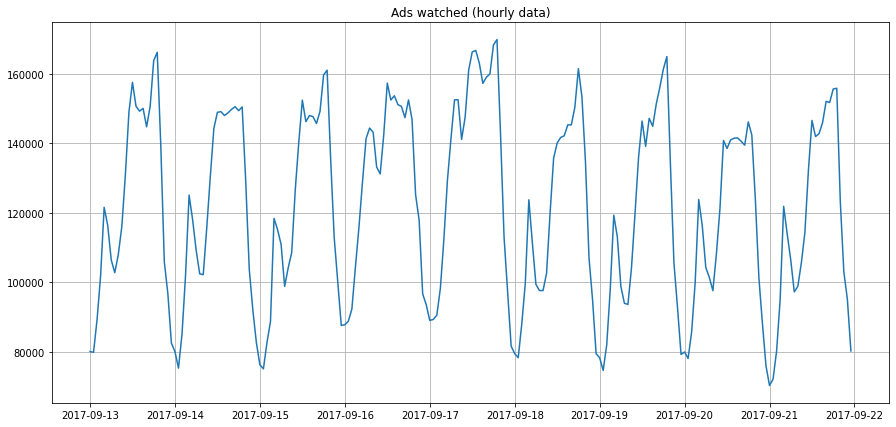

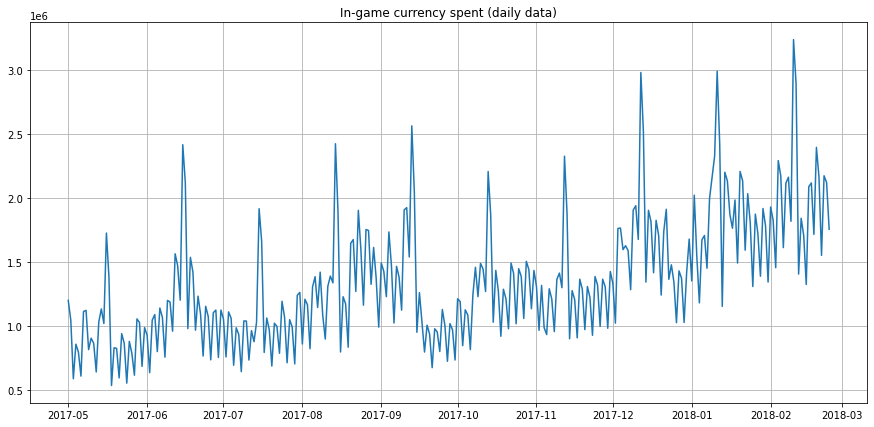

In [3]:
#real mobile game data on hourly ads watched by players

ads = pd.read_csv('data/ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])

plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

In [4]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [5]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


In [6]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,7))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

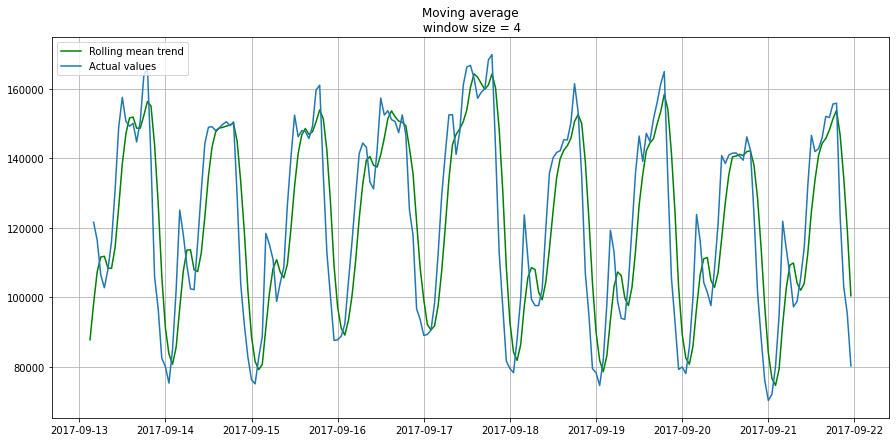

In [7]:
plotMovingAverage(ads, 4)

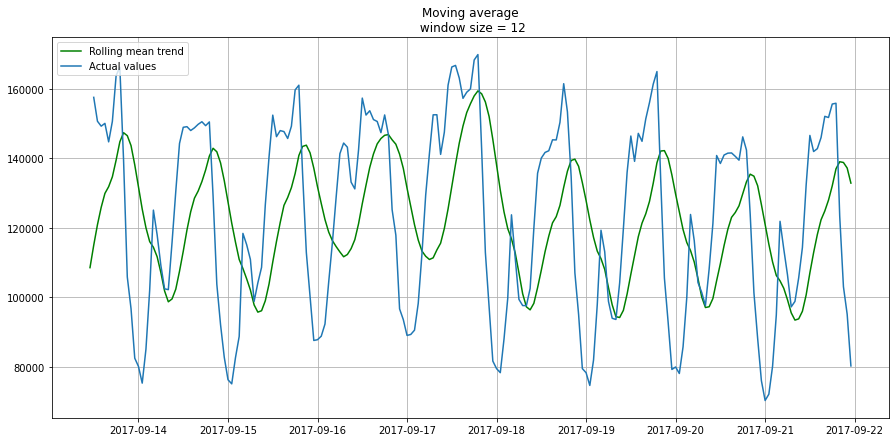

In [8]:
plotMovingAverage(ads, 12)

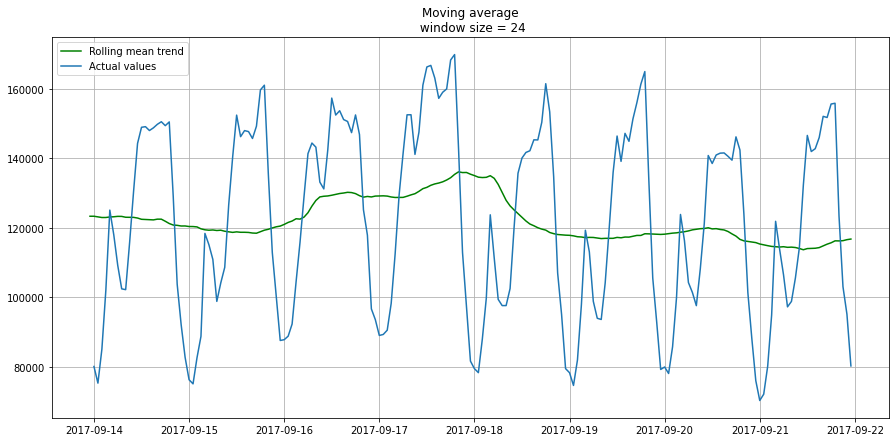

In [9]:
plotMovingAverage(ads, 24)

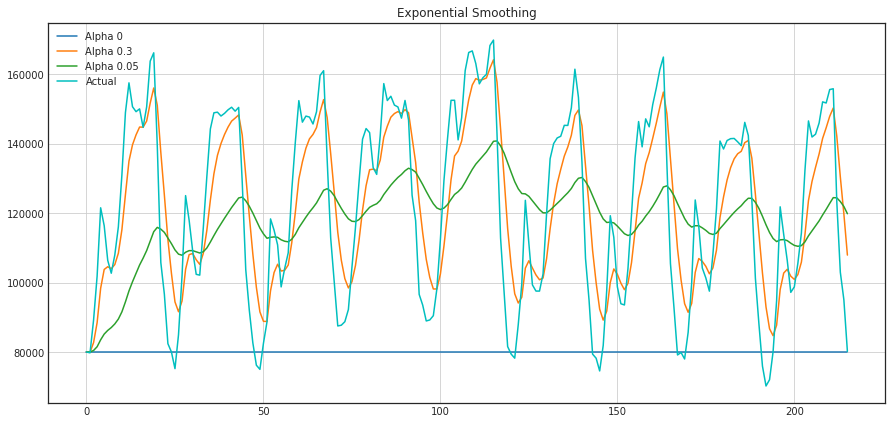

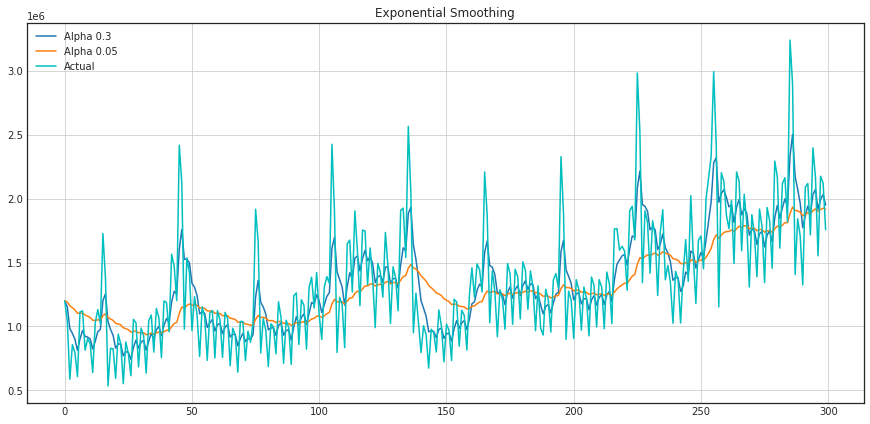

In [10]:
def exponential_smoothing(series, alpha):
    """
        series - dataset with timestamps
        alpha - float [0.0, 1.0], smoothing parameter
    """
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
    
def plotExponentialSmoothing(series, alphas):
    """
        Plots exponential smoothing with different alphas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters
        
    """
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(15, 7))
        for alpha in alphas:
            plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
        plt.plot(series.values, "c", label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Exponential Smoothing")
        plt.grid(True);
        
plotExponentialSmoothing(ads.Ads, [0, 0.3, 0.05])
plotExponentialSmoothing(currency.GEMS_GEMS_SPENT, [0.3, 0.05])

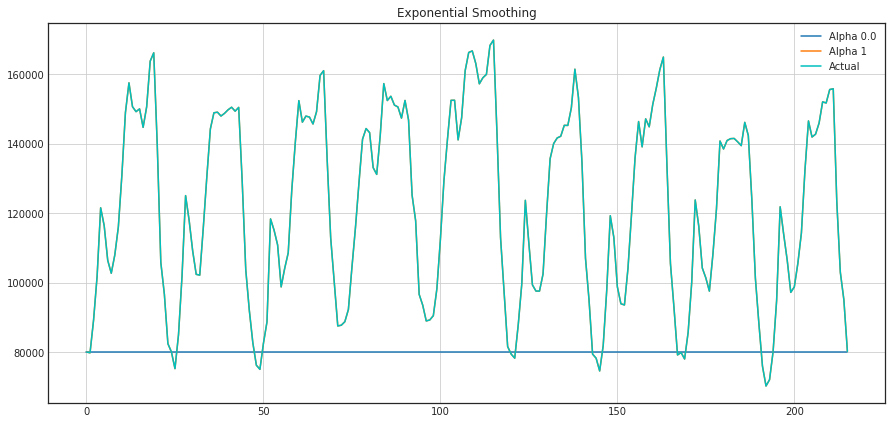

In [11]:
plotExponentialSmoothing(ads.Ads, [0.0, 1])

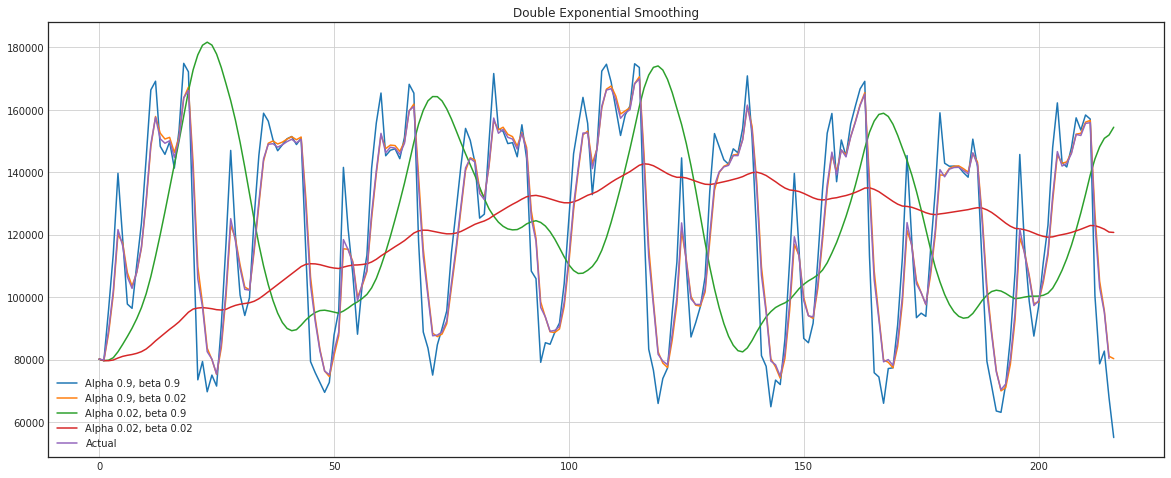

In [12]:
def double_exponential_smoothing(series, alpha, beta):
    """
        series - dataset with timeseries
        alpha - float [0.0, 1.0], smoothing parameter for level
        beta - float [0.0, 1.0], smoothing parameter for trend
    """
    # first value is same as series
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

def plotDoubleExponentialSmoothing(series, alphas, betas):
    """
        Plots double exponential smoothing with different alphas and betas
        
        series - dataset with timestamps
        alphas - list of floats, smoothing parameters for level
        betas - list of floats, smoothing parameters for trend
    """
    
    with plt.style.context('seaborn-white'):    
        plt.figure(figsize=(20, 8))
        for alpha in alphas:
            for beta in betas:
                plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
        plt.plot(series.values, label = "Actual")
        plt.legend(loc="best")
        plt.axis('tight')
        plt.title("Double Exponential Smoothing")
        plt.grid(True)
        
plotDoubleExponentialSmoothing(ads.Ads, alphas=[0.9, 0.02], betas=[0.9, 0.02])
#plotDoubleExponentialSmoothing(currency.GEMS_GEMS_SPENT, alphas=[0.9, 0.02], betas=[0.9, 0.02])

In [13]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [14]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [15]:
%%time
data = ads.Ads[:-20] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_log_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 200, scaling_factor = 3)
model.triple_exponential_smoothing()

0.11652680227350454 0.002677697431105852 0.05820973606789237
CPU times: user 2.76 s, sys: 33.1 ms, total: 2.8 s
Wall time: 2.82 s


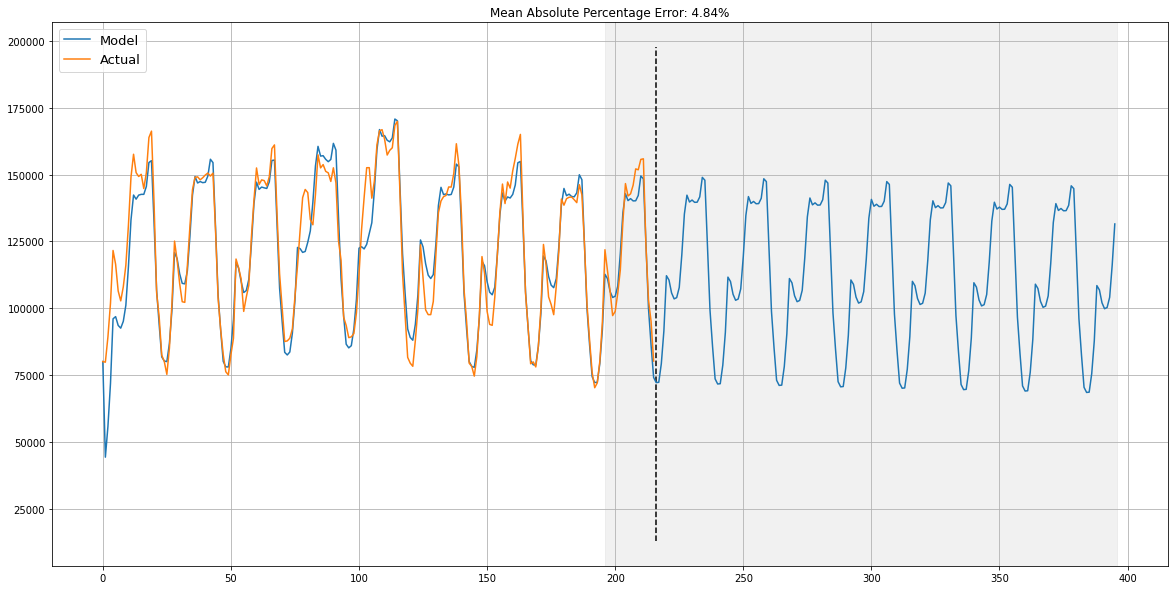

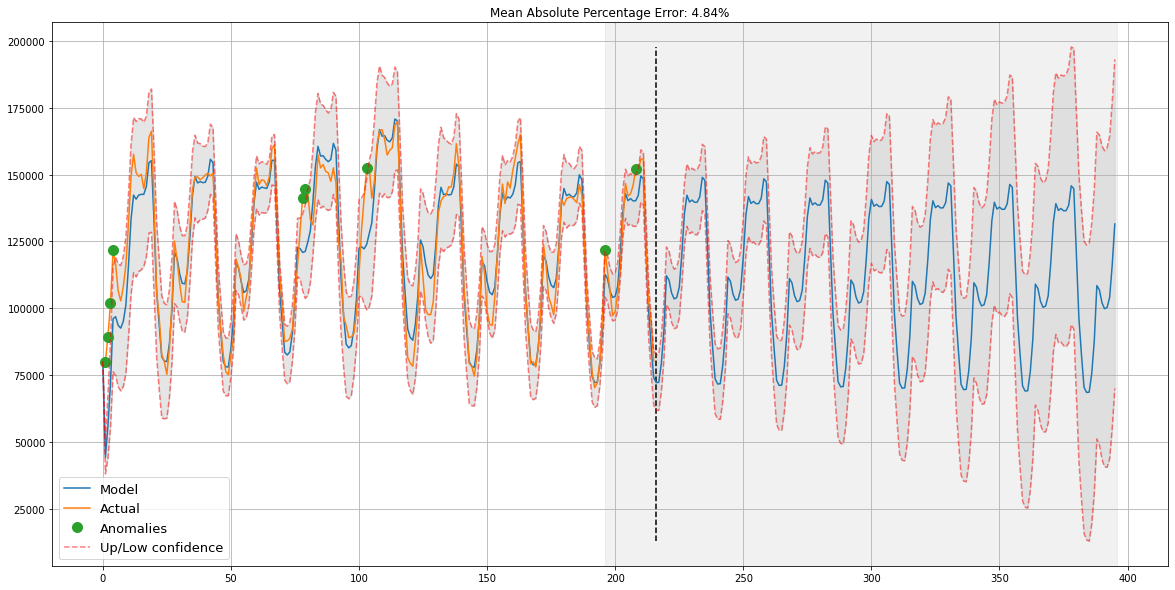

In [16]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);
    
plotHoltWinters(ads.Ads)
plotHoltWinters(ads.Ads, plot_intervals=True, plot_anomalies=True)

## SMRIMA

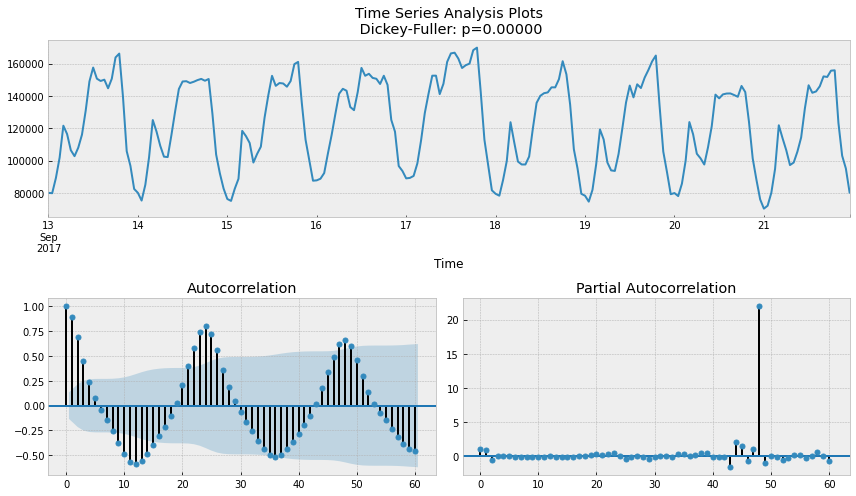

In [17]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(ads.Ads, lags=60)

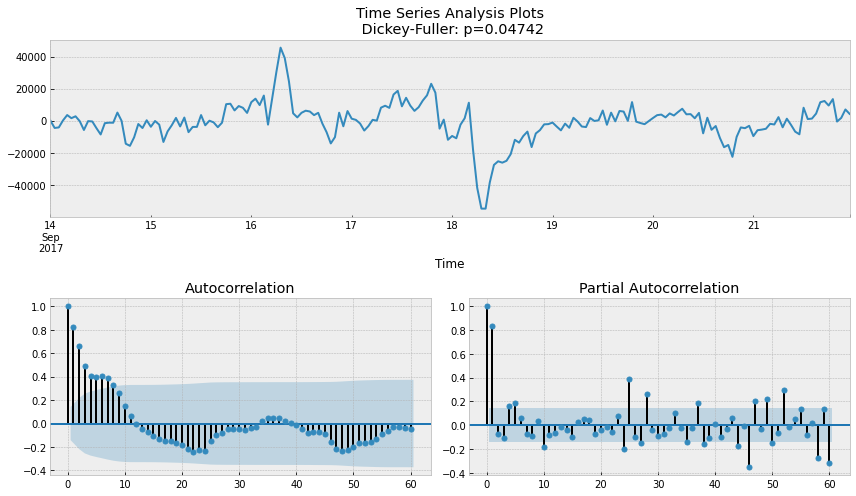

In [18]:
ads_diff = ads.Ads - ads.Ads.shift(24)
tsplot(ads_diff[24:], lags=60)

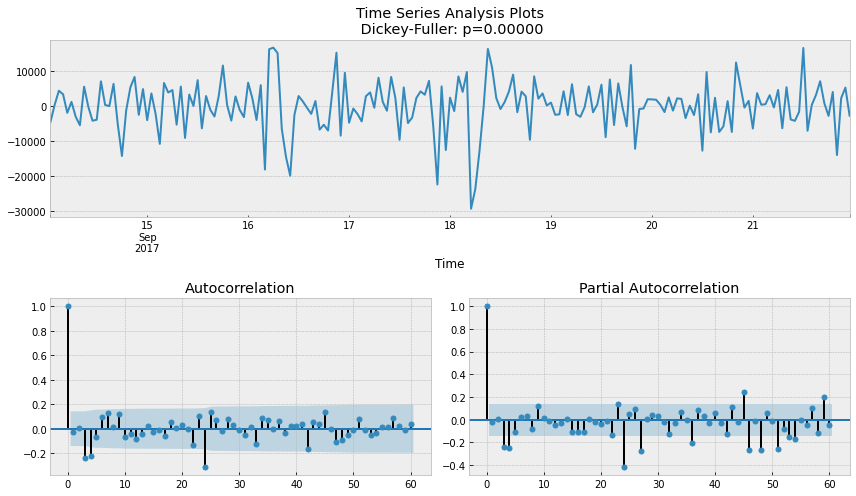

In [19]:
ads_diff = ads_diff - ads_diff.shift(1)
tsplot(ads_diff[24+1:], lags=60)

In [20]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 3)
D=1 
Qs = range(0, 2)
s = 24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [21]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table
    
result_table = optimizeSARIMA(parameters_list, d, D, s)

In [22]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(ads.Ads, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                  Ads   No. Observations:                  216
Model:             SARIMAX(2, 1, 3)x(1, 1, [1], 24)   Log Likelihood               -1936.321
Date:                              Thu, 03 Sep 2020   AIC                           3888.642
Time:                                      20:03:48   BIC                           3914.660
Sample:                                  09-13-2017   HQIC                          3899.181
                                       - 09-21-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.270      2.928      0.003       0.262       1.321
ar.L2         -0.55

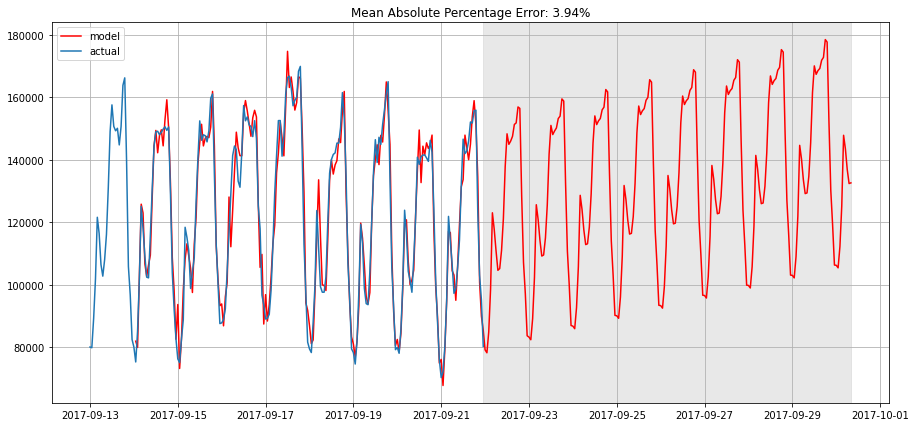

In [23]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);
    
plotSARIMA(ads, best_model, 200)

## Prophet

In [24]:
from fbprophet import Prophet

In [25]:
ads = pd.read_csv('data/ads.csv')
ads1 = ads.rename(columns={'Time':'ds', 'Ads':'y'})
ads1

,ds,y
0,2017-09-13T00:00:00,80115
1,2017-09-13T01:00:00,79885
2,2017-09-13T02:00:00,89325
3,2017-09-13T03:00:00,101930
4,2017-09-13T04:00:00,121630
...,...,...
211,2017-09-21T19:00:00,155890
212,2017-09-21T20:00:00,123395
213,2017-09-21T21:00:00,103080
214,2017-09-21T22:00:00,95155


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

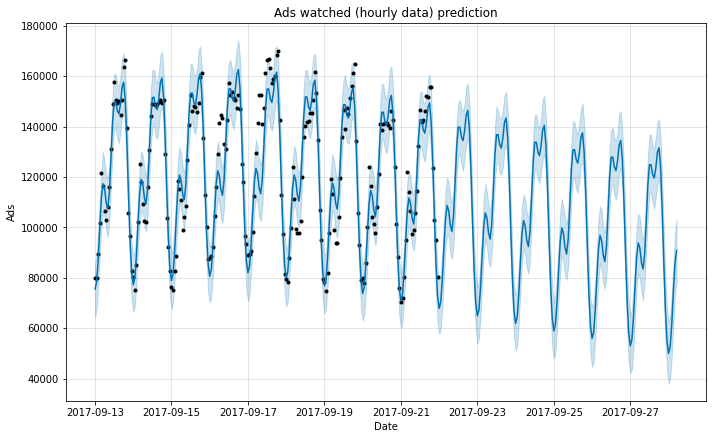

In [26]:
ads_model = Prophet()
ads_model.fit(ads1)

#ads_forecast = ads_model.make_future_dataframe(periods=36, freq='MS')
ads_forecast = ads_model.make_future_dataframe(periods=150, freq='H')
ads_forecast = ads_model.predict(ads_forecast)

plt.figure(figsize=(18, 6))
ads_model.plot(ads_forecast, xlabel = 'Date', ylabel = 'Ads')
plt.title('Ads watched (hourly data) prediction');

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

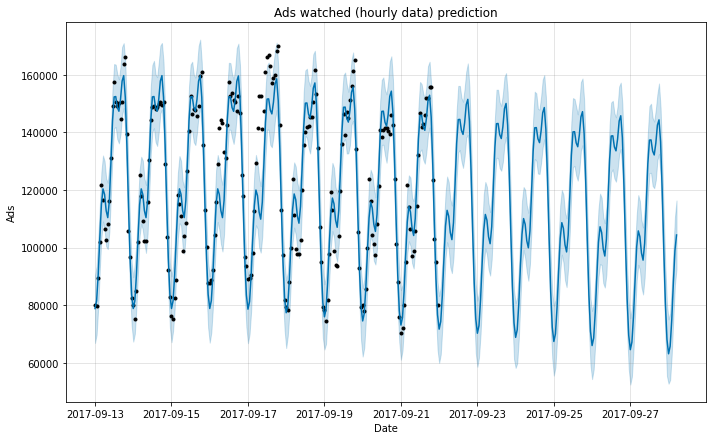

In [27]:
ads_model = Prophet(changepoint_prior_scale = 0.01)
ads_model.fit(ads1)

#ads_forecast = ads_model.make_future_dataframe(periods=36, freq='MS')
ads_forecast = ads_model.make_future_dataframe(periods=150, freq='H')
ads_forecast = ads_model.predict(ads_forecast)

plt.figure(figsize=(18, 6))
ads_model.plot(ads_forecast, xlabel = 'Date', ylabel = 'Ads')
plt.title('Ads watched (hourly data) prediction');

## LSTM

reference

https://medium.com/swlh/a-quick-example-of-time-series-forecasting-using-long-short-term-memory-lstm-networks-ddc10dc1467d

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
#from keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

In [38]:
ads = pd.read_csv('data/ads.csv')
ads['Time'] = pd.to_datetime(ads['Time'])
ads = ads.set_index("Time")
print(ads.shape)
ads.head(15)

(216, 1)


,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630
2017-09-13 05:00:00,116475
2017-09-13 06:00:00,106495
2017-09-13 07:00:00,102795
2017-09-13 08:00:00,108055


In [39]:
train, test = ads[:-20], ads[-20:]
test

,Ads
Time,
2017-09-21 04:00:00,121910
2017-09-21 05:00:00,113950
2017-09-21 06:00:00,106495
2017-09-21 07:00:00,97290
2017-09-21 08:00:00,98860
2017-09-21 09:00:00,105635
2017-09-21 10:00:00,114380
2017-09-21 11:00:00,132335
2017-09-21 12:00:00,146630


In [40]:
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

In [41]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

model = tf.keras.Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=90)

Epoch 1/90
31/31 [==============================] - 0s 8ms/step - loss: 0.1072
Epoch 2/90
31/31 [==============================] - 0s 7ms/step - loss: 0.0696
Epoch 3/90
31/31 [==============================] - 0s 11ms/step - loss: 0.0624
Epoch 4/90
31/31 [==============================] - 0s 8ms/step - loss: 0.0443
Epoch 5/90
31/31 [==============================] - 0s 7ms/step - loss: 0.0375
Epoch 6/90
31/31 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 7/90
31/31 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 8/90
31/31 [==============================] - 0s 8ms/step - loss: 0.0298
Epoch 9/90
31/31 [==============================] - 0s 7ms/step - loss: 0.0287
Epoch 10/90
31/31 [==============================] - 0s 7ms/step - loss: 0.0258
Epoch 11/90
31/31 [==============================] - 0s 7ms/step - loss: 0.0251
Epoch 12/90
31/31 [==============================] - 0s 7ms/step - loss: 0.0203
Epoch 13/90
31/31 [=============================

In [42]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

In [43]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=ads[-n_input:].index, columns=['Prediction'])
df_test = pd.concat([ads,df_predict], axis=1)

In [44]:
df_predict

,Prediction
Time,
2017-09-21 12:00:00,115634.014085
2017-09-21 13:00:00,127416.789937
2017-09-21 14:00:00,133112.508778
2017-09-21 15:00:00,137909.626043
2017-09-21 16:00:00,144242.144384
2017-09-21 17:00:00,152997.799240
2017-09-21 18:00:00,163238.969459
2017-09-21 19:00:00,173261.938641
2017-09-21 20:00:00,181139.442334


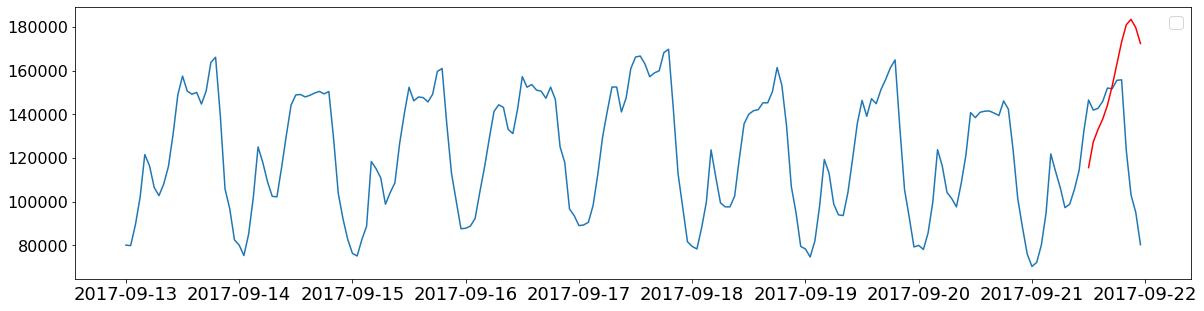

In [45]:
plt.figure(figsize=(20, 5))
plt.plot(df_test.index, df_test['Ads'])
plt.plot(df_test.index, df_test['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [49]:
train = ads
scaler.fit(train)
train = scaler.transform(train)
n_input = 150
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)
model.fit_generator(generator,epochs=200)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/200
11/11 [==============================] - 1s 59ms/step - loss: 0.0049
Epoch 2/200
11/11 [==============================] - 1s 57ms/step - loss: 0.0066
Epoch 3/200
11/11 [==============================] - 1s 53ms/step - loss: 0.0049
Epoch 4/200
11/11 [==============================] - 1s 55ms/step - loss: 0.0067
Epoch 5/200
11/11 [==============================] - 1s 53ms/step - loss: 0.0060
Epoch 6/200
11/11 [==============================] - 1s 54ms/step - loss: 0.0055
Epoch 7/200
11/11 [==============================] - 1s 56ms/step - loss: 0.0057
Epoch 8/200
11/11 [==============================] - 1s 56ms/step - loss: 0.0054
Epoch 9/200
11/11 [==============================] - 1s 56ms/step - loss: 0.0061
Epoch 10/200
11/11 [==============================] - 1s 54ms/step - loss: 0.0044
Epoch 11/200
11/11 [==============================] - 1s 53ms/step - loss: 0.0048
Epoch 12/200
11/11 [==============================] - 1s 53ms/step - loss: 0.0064
Epoch 13/200
11/11 [=====

11/11 [==============================] - 1s 49ms/step - loss: 0.0037
Epoch 102/200
11/11 [==============================] - 1s 53ms/step - loss: 0.0031
Epoch 103/200
11/11 [==============================] - 1s 50ms/step - loss: 0.0030
Epoch 104/200
11/11 [==============================] - 1s 50ms/step - loss: 0.0037
Epoch 105/200
11/11 [==============================] - 1s 50ms/step - loss: 0.0038
Epoch 106/200
11/11 [==============================] - 1s 50ms/step - loss: 0.0037
Epoch 107/200
11/11 [==============================] - 1s 49ms/step - loss: 0.0039
Epoch 108/200
11/11 [==============================] - 1s 51ms/step - loss: 0.0047
Epoch 109/200
11/11 [==============================] - 1s 51ms/step - loss: 0.0036
Epoch 110/200
11/11 [==============================] - 1s 51ms/step - loss: 0.0055
Epoch 111/200
11/11 [==============================] - 1s 53ms/step - loss: 0.0033
Epoch 112/200
11/11 [==============================] - 1s 50ms/step - loss: 0.0035
Epoch 113/200
11/1

11/11 [==============================] - 1s 53ms/step - loss: 0.0025
Epoch 200/200
11/11 [==============================] - 1s 51ms/step - loss: 0.0041


In [50]:
from pandas.tseries.offsets import DateOffset

add_dates = [ads.index[-1] + DateOffset(hours=x) for x in range(0,151) ]
future_hours = pd.DataFrame(index=add_dates[1:],columns=ads.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_hours[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([ads,df_predict], axis=1)

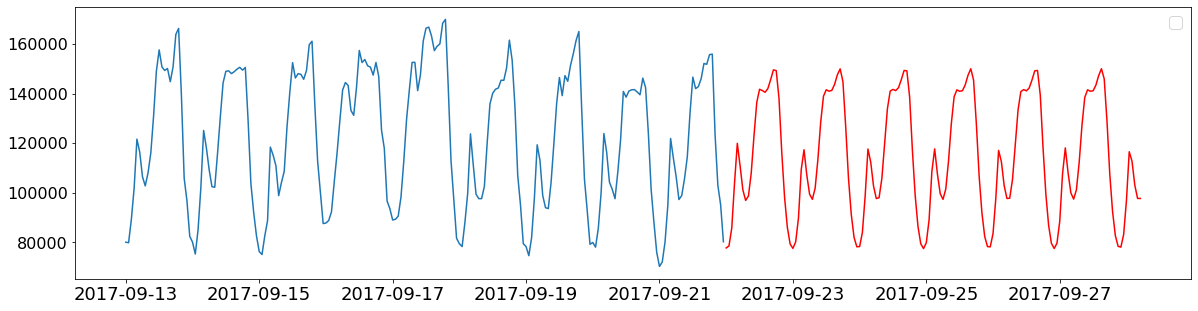

In [51]:
plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Ads'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [52]:
ads = pd.read_csv('data/ads.csv')
ads['Time'] = pd.to_datetime(ads['Time'])
ads = ads.set_index("Time")
print(ads.shape)

train, test = ads[:-20], ads[-20:]


scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

(216, 1)


In [53]:
model = tf.keras.Sequential()

model.add(LSTM(200, activation='relu', return_sequences = True, input_shape=(n_input, n_features)))
model.add(Dropout(0.15))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(100,  return_sequences = True, activation='relu'))
model.add(Dropout(0.15))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(50, return_sequences = True, activation='relu'))
model.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(50))
model.add(Dropout(0.2))

#Adding the output layer
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [54]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 150, 200)          161600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 200)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 100)          120400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 50)           30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 50)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)               

In [57]:
train = ads
scaler.fit(train)
train = scaler.transform(train)
n_input = 150
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

model.fit_generator(generator,epochs=200)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/200
11/11 [==============================] - 2s 148ms/step - loss: 0.0102
Epoch 2/200
11/11 [==============================] - 2s 140ms/step - loss: 0.0098
Epoch 3/200
11/11 [==============================] - 2s 139ms/step - loss: 0.0096
Epoch 4/200
11/11 [==============================] - 2s 141ms/step - loss: 0.0108
Epoch 5/200
11/11 [==============================] - 2s 145ms/step - loss: 0.0082
Epoch 6/200
11/11 [==============================] - 2s 143ms/step - loss: 0.0096
Epoch 7/200
11/11 [==============================] - 2s 144ms/step - loss: 0.0093
Epoch 8/200
11/11 [==============================] - 2s 146ms/step - loss: 0.0113
Epoch 9/200
11/11 [==============================] - 2s 142ms/step - loss: 0.0087
Epoch 10/200
11/11 [==============================] - 2s 140ms/step - loss: 0.0127
Epoch 11/200
11/11 [==============================] - 2s 142ms/step - loss: 0.0092
Epoch 12/200
11/11 [==============================] - 2s 142ms/step - loss: 0.0087
Epoch 13/200


11/11 [==============================] - 2s 186ms/step - loss: 0.0085
Epoch 100/200
11/11 [==============================] - 2s 148ms/step - loss: 0.0086
Epoch 101/200
11/11 [==============================] - 2s 142ms/step - loss: 0.0089
Epoch 102/200
11/11 [==============================] - 2s 148ms/step - loss: 0.0080
Epoch 103/200
11/11 [==============================] - 2s 143ms/step - loss: 0.0076
Epoch 104/200
11/11 [==============================] - 2s 147ms/step - loss: 0.0054
Epoch 105/200
11/11 [==============================] - 2s 146ms/step - loss: 0.0057
Epoch 106/200
11/11 [==============================] - 2s 151ms/step - loss: 0.0057
Epoch 107/200
11/11 [==============================] - 2s 159ms/step - loss: 0.0068
Epoch 108/200
11/11 [==============================] - 2s 151ms/step - loss: 0.0058
Epoch 109/200
11/11 [==============================] - 2s 143ms/step - loss: 0.0046
Epoch 110/200
11/11 [==============================] - 2s 144ms/step - loss: 0.0060
Epoch 

11/11 [==============================] - 2s 152ms/step - loss: 0.0076
Epoch 197/200
11/11 [==============================] - 2s 145ms/step - loss: 0.0099
Epoch 198/200
11/11 [==============================] - 2s 146ms/step - loss: 0.0098
Epoch 199/200
11/11 [==============================] - 2s 150ms/step - loss: 0.0151
Epoch 200/200
11/11 [==============================] - 2s 160ms/step - loss: 0.0111


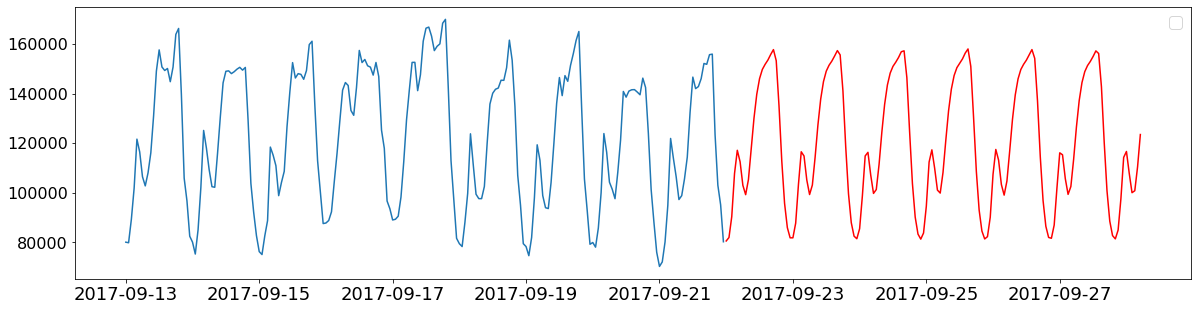

In [58]:
add_dates = [ads.index[-1] + DateOffset(hours=x) for x in range(0,151) ]
future_hours = pd.DataFrame(index=add_dates[1:],columns=ads.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_hours[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([ads,df_predict], axis=1)

plt.figure(figsize=(20, 5))
plt.plot(df_proj.index, df_proj['Ads'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

# IBM Stock

In [59]:
ls data

IBM_stock.csv  LSTM2.png      ads.csv        ads1.csv       currency.csv


In [69]:
ibm = pd.read_csv('data/IBM_stock.csv')
ibm

,date,open,high,low,close,volume
0,1/2/62,14.4361,14.4361,14.2739,14.2739,387200
1,1/3/62,14.2739,14.3987,14.2739,14.3987,288000
2,1/4/62,14.3987,14.3987,14.2490,14.2552,256000
3,1/5/62,14.2365,14.2365,13.9495,13.9745,363200
4,1/8/62,13.9620,13.9620,13.6002,13.7125,544000
...,...,...,...,...,...,...
14766,8/28/20,124.9600,125.3000,124.2187,125.0700,3099623
14767,8/31/20,125.2500,125.2500,123.0300,123.3100,4824775
14768,9/1/20,122.8500,123.9500,122.1500,123.4000,3155341
14769,9/2/20,123.7200,128.7000,123.5750,128.1800,6579289


In [70]:
ibm = ibm[-1000:].reset_index(drop=True)
ibm

,date,open,high,low,close,volume
0,9/15/16,139.1574,140.9882,138.1744,140.3840,3662573
1,9/16/16,139.8248,140.1495,138.4089,138.7426,6463213
2,9/19/16,139.6715,140.8620,139.3829,139.6715,2450117
3,9/20/16,140.5734,141.2047,139.2927,139.2927,2159092
4,9/21/16,139.7076,140.4020,138.7696,140.2667,2473895
...,...,...,...,...,...,...
995,8/28/20,124.9600,125.3000,124.2187,125.0700,3099623
996,8/31/20,125.2500,125.2500,123.0300,123.3100,4824775
997,9/1/20,122.8500,123.9500,122.1500,123.4000,3155341
998,9/2/20,123.7200,128.7000,123.5750,128.1800,6579289


In [71]:
ibm['date']  = pd.to_datetime(ibm['date'])
ibm.head()

,date,open,high,low,close,volume
0,2016-09-15,139.1574,140.9882,138.1744,140.3840,3662573
1,2016-09-16,139.8248,140.1495,138.4089,138.7426,6463213
2,2016-09-19,139.6715,140.8620,139.3829,139.6715,2450117
3,2016-09-20,140.5734,141.2047,139.2927,139.2927,2159092
4,2016-09-21,139.7076,140.4020,138.7696,140.2667,2473895


In [72]:
ibm['mean'] = (ibm['high'] + ibm['low'])/2
ibm = ibm.rename(columns={'date':'ds','mean':'y'})

In [73]:
ibm

,ds,open,high,low,close,volume,y
0,2016-09-15,139.1574,140.9882,138.1744,140.3840,3662573,139.58130
1,2016-09-16,139.8248,140.1495,138.4089,138.7426,6463213,139.27920
2,2016-09-19,139.6715,140.8620,139.3829,139.6715,2450117,140.12245
3,2016-09-20,140.5734,141.2047,139.2927,139.2927,2159092,140.24870
4,2016-09-21,139.7076,140.4020,138.7696,140.2667,2473895,139.58580
...,...,...,...,...,...,...,...
995,2020-08-28,124.9600,125.3000,124.2187,125.0700,3099623,124.75935
996,2020-08-31,125.2500,125.2500,123.0300,123.3100,4824775,124.14000
997,2020-09-01,122.8500,123.9500,122.1500,123.4000,3155341,123.05000
998,2020-09-02,123.7200,128.7000,123.5750,128.1800,6579289,126.13750


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

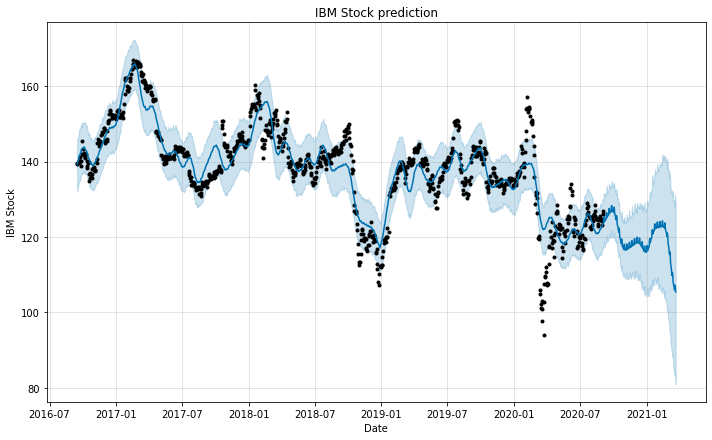

In [79]:
ibm_model = Prophet()
ibm_model.fit(ibm[['ds','y']])

ibm_forecast = ibm_model.make_future_dataframe(periods=200, freq='D')
ibm_forecast = ibm_model.predict(ibm_forecast)

plt.figure(figsize=(18, 6))
ibm_model.plot(ibm_forecast, xlabel = 'Date', ylabel = 'IBM Stock')
plt.title('IBM Stock prediction');

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

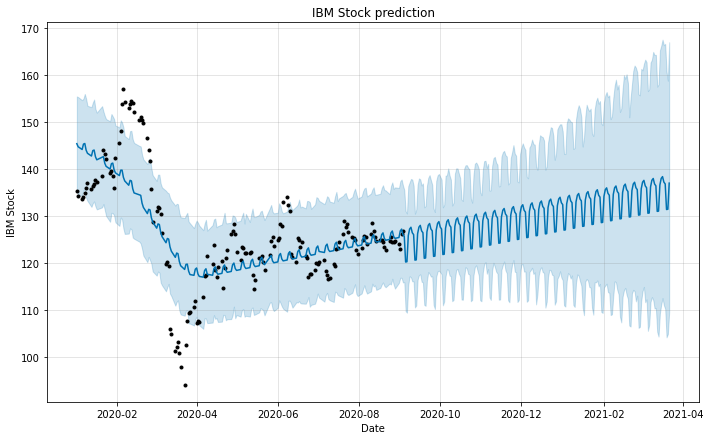

In [88]:
ibm_model = Prophet()
ibm_model.fit(ibm[ibm.ds>'2019-12-31'])

ibm_forecast = ibm_model.make_future_dataframe(periods=200, freq='D')
ibm_forecast = ibm_model.predict(ibm_forecast)

plt.figure(figsize=(18, 6))
ibm_model.plot(ibm_forecast, xlabel = 'Date', ylabel = 'IBM Stock')
plt.title('IBM Stock prediction');

In [124]:
#n_input = 200
n_input = 170
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

model = tf.keras.Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


train = ibm[ibm.ds>'2019-12-31'][['ds','y']].set_index('ds')
scaler.fit(train)
train = scaler.transform(train)
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

model.fit_generator(generator,epochs=100)
pred_list = []  
batch = train[-n_input:].reshape((1, n_input, n_features))
for i in range(n_input):
    pred_list.append(model.predict(batch)[0])      
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.2966
Epoch 2/100
1/1 [==============================] - 0s 860us/step - loss: 0.2425
Epoch 3/100
1/1 [==============================] - 0s 868us/step - loss: 0.2273
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1976
Epoch 5/100
1/1 [==============================] - 0s 957us/step - loss: 0.1688
Epoch 6/100
1/1 [==============================] - 0s 949us/step - loss: 0.1711
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.1367
Epoch 8/100
1/1 [==============================] - 0s 995us/step - loss: 0.1078
Epoch 9/100
1/1 [==============================] - 0s 918us/step - loss: 0.0718
Epoch 10/100
1/1 [==============================] - 0s 935us/step - loss: 0.0421
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.0171
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0128
Epoch 13/100
1/1 [=============================

In [139]:
#scaler.inverse_transform(pred_list)

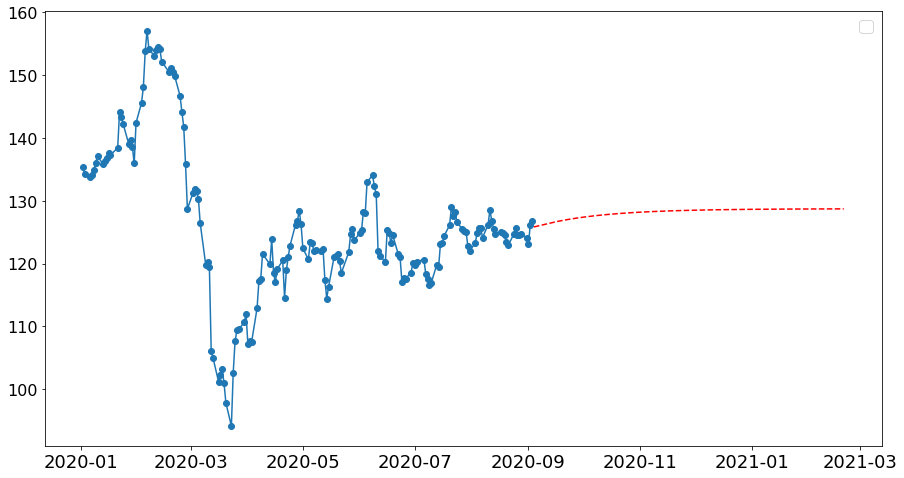

In [138]:
from pandas.tseries.offsets import DateOffset

#ibm1 = ibm[['ds','y']].set_index('ds')
ibm1 = ibm[ibm.ds>'2019-12-31'][['ds','y']].set_index('ds')

ibm_dates = [ibm1.index[-1] + DateOffset(days=x) for x in range(0,171) ]
future_days = pd.DataFrame(index=ibm_dates[1:],columns=ibm1.columns)

df_predict = pd.DataFrame(scaler.inverse_transform(pred_list),
                          index=future_days[-n_input:].index, columns=['Prediction'])

df_proj = pd.concat([ibm1,df_predict], axis=1)


plt.figure(figsize=(15, 8))
plt.scatter(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r', linestyle='--')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [143]:
from pmdarima.arima import auto_arima

In [182]:
ibm1 = ibm[['ds','y']].set_index('ds')

stepwise_model = auto_arima(ibm1, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=17.61 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=4677.118, Time=0.13 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=4362.677, Time=1.06 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=11.47 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=4640.588, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=4247.661, Time=2.36 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=28.74 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=10.44 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=4263.773, Time=1.87 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=4248.847, Time=3.63 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=4248.108, Time=5.09 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=4248.695, Time=2.68 sec
 ARIMA(2,1,1)(2,1,0)[24]             : AIC=4249.428, Time=9.30 sec
 ARIMA(1,1,0)(2,1,0)[24] intercept   : AIC=4249.660, Time=14.76 sec

Best model:  ARIMA(1,1,0)(2,1,0)[

In [183]:
train = ibm1.loc[:'2019-12-31']
test = ibm1.loc['2019-12-31':]

In [184]:
stepwise_model.fit(train)

future_forecast = stepwise_model.predict(n_periods=172)

In [165]:
#future_forecast

In [185]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
df_proj = pd.concat([test,future_forecast],axis=1)
df_proj

,y,Prediction
ds,,
2019-12-31,133.26000,134.214904
2020-01-02,135.34505,133.806774
2020-01-03,134.21000,133.308583
2020-01-06,133.72000,133.739247
2020-01-07,134.18000,132.649757
...,...,...
2020-08-28,124.75935,120.897869
2020-08-31,124.14000,121.602870
2020-09-01,123.05000,121.226218


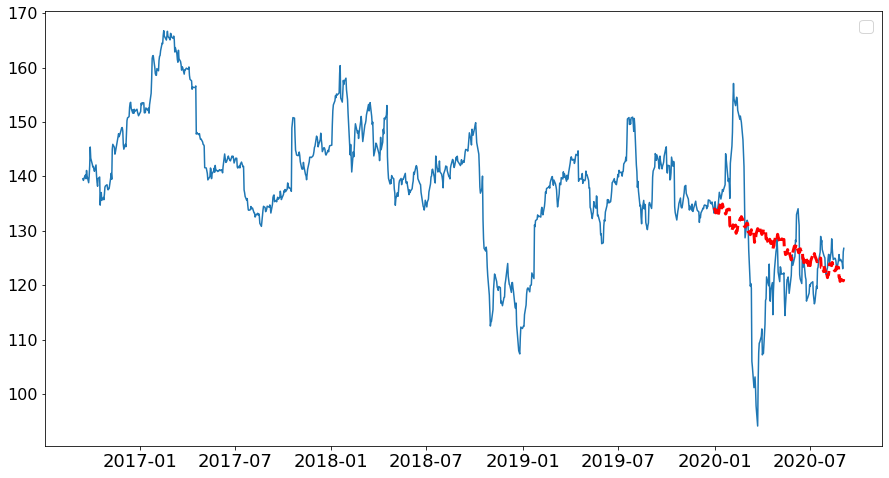

In [195]:
plt.figure(figsize=(15, 8))
#plt.scatter(df_proj.index, df_proj['y'])
plt.plot(ibm1.index, ibm1['y'])
#plt.plot(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r', linestyle='--', linewidth=3.0)
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [189]:
ibm1 = ibm[['ds','y']].set_index('ds')

stepwise_model = auto_arima(ibm1, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=24,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[24]             : AIC=inf, Time=17.64 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=4677.118, Time=0.14 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=4362.677, Time=0.96 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=11.91 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=4640.588, Time=0.22 sec
 ARIMA(1,1,0)(2,1,0)[24]             : AIC=4247.661, Time=2.28 sec
 ARIMA(1,1,0)(2,1,1)[24]             : AIC=inf, Time=24.91 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=9.66 sec
 ARIMA(0,1,0)(2,1,0)[24]             : AIC=4263.773, Time=2.03 sec
 ARIMA(2,1,0)(2,1,0)[24]             : AIC=4248.847, Time=3.90 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=4248.108, Time=4.89 sec
 ARIMA(0,1,1)(2,1,0)[24]             : AIC=4248.695, Time=3.49 sec
 ARIMA(2,1,1)(2,1,0)[24]             : AIC=4249.428, Time=8.79 sec
 ARIMA(1,1,0)(2,1,0)[24] intercept   : AIC=4249.660, Time=10.10 sec

Best model:  ARIMA(1,1,0)(2,1,0)[2

In [196]:
stepwise_model.fit(ibm1)

future_forecast = stepwise_model.predict(n_periods=200)

In [210]:
ibm_dates = [ibm1.index[-1] + DateOffset(days=x) for x in range(0,201) ]
future_days = pd.DataFrame(index=ibm_dates[1:],columns=ibm1.columns)

df_predict = pd.DataFrame(future_forecast,index=future_days[-200:].index, columns=['Prediction'])

df_proj = pd.concat([ibm1,df_predict], axis=1)

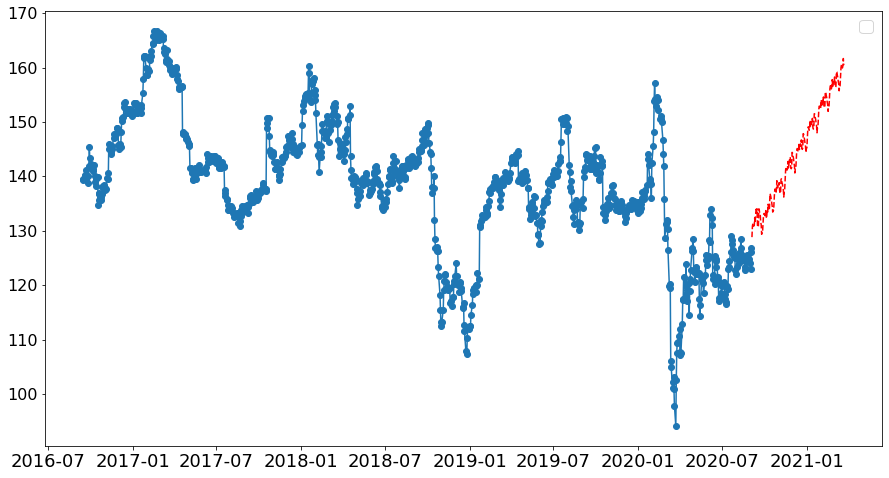

In [212]:
plt.figure(figsize=(15, 8))
plt.scatter(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r', linestyle='--')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

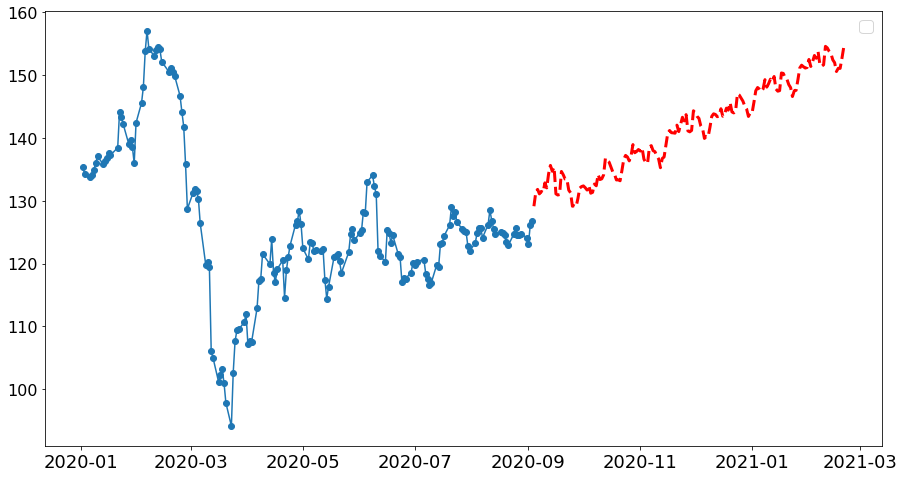

In [215]:
ibm1 = ibm[ibm.ds>'2019-12-31'][['ds','y']].set_index('ds')

stepwise_model.fit(ibm1)
future_forecast = stepwise_model.predict(n_periods=170)

ibm_dates = [ibm1.index[-1] + DateOffset(days=x) for x in range(0,171) ]
future_days = pd.DataFrame(index=ibm_dates[1:],columns=ibm1.columns)

df_predict = pd.DataFrame(future_forecast,index=future_days[-170:].index, columns=['Prediction'])

df_proj = pd.concat([ibm1,df_predict], axis=1)

plt.figure(figsize=(15, 8))
plt.scatter(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['y'])
plt.plot(df_proj.index, df_proj['Prediction'], color='r', linestyle='--', linewidth=3.0)
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()